# Interprétation des paramètres géotechniques utilisés pour la réalisation des PSHM du J-SHIS

Lecture des fichiers j-shis 
Se référer au file format specification sur le site de j-shis (http://www.j-shis.bosai.go.jp/map/JSHIS2/data/DOC/DataFileRule/A-RULES_en.pdf)

In [1]:
from EQCAT.parse_files import *
%matplotlib inline

## Failles actives

Les failles actives reproduisent des séismes survenant sur les terres Japonaises de manière régulière et avec une surface de rupture identique représentée par un ou un ensemble de rectangle. Elles se divisent en 2 grandes catégories : les failles actives majeures dont le code commence par un "F" et les autres failles actives dont le code commence par un "G".

Les informations les concernant se trouvent dans les fichiers :
- "Parameters for seismic activity evaluation"
- "Fault shape (rectangle)"

De plus, pour certaines des failles actives majeures, des traces de séismes passés ont permis d'obtenir d'avantage d'informations sur la loi de probabilité de leur magnitude. Ces informations se trouvent dans le fichier "Parameters for seismic activity evaluation and Fault shape of EarthQuake’s Traces Hardly Recognized (EQTHR) from surface evidences".

De plus, lors de l'évaluation de l'activité de certains ensembles de failles actives majeures, la rupture de chacune des failles dans le même intervalle de temps équivaut à la rupture simultanée de toutes les failles alors appelées segments. Dans ce cas, on considère un évènement unique et la surface de rupture est la réunion de surfaces de ruptures des failles.  Ces informations se trouvent dans le fichier "MultiActivity".

In [2]:
yesy = parse_quakes('all active faults')

Parsing major active faults with EQTHR : 224 sources
 - 224 magnitudes/process parsed
 - 249 rectangles parsed
Parsing  seismic activity for all active faults : 406 sources
Nb sources updated : 135
Nb new sources : 184
Parsing sources triggered by simulated occurrences : 33 sources
Nb sources updated : 32
Parsing rectangles : 8 files
 - Nb planes parsed : 299
 - Nb mags parsed : 184
 - Nb sources updated : 408


In [12]:
output = pd.DataFrame(columns=['Code', 'Name', 'ProcessType', 'Process', 'MagnitudeType', 'Magnitude', 'ShapeType', 'Shape'])
for cp in yesy:
    seisme = yesy[cp]
    output.loc[len(output)] = [seisme.code, seisme.name, seisme.proc.type, seisme.proc.desc(), seisme.mag.type,
                               seisme.mag.desc(), seisme.shape.type, seisme.shape.shape_coord]
output.to_csv(results_path + parsing_reports_path + '01-Active Faults/active_faults_report.csv', sep=',', index=False)
output.head()

,Code,Name,ProcessType,Process,MagnitudeType,Magnitude,ShapeType,Shape
0,F019101,Ube-Nanpou-oki fault,PoissonProcess,P(lmbd=0.0),CharacteristicMag,CHAR(mag=6.38),MultiPlaneShape,"(POLYGON ((131.28 33.893, 131.3128580364981 33..."
1,F005102,Inadani fault zone (Southeastern part),PoissonProcess,P(lmbd=0.0),GutenbergRichter,"GR(min=6.38,b_val=0.9,max=6.77)",MultiPlaneShape,"(POLYGON ((137.829 35.517, 137.7005147131509 3..."
2,F005101,Inadani fault zone (Main part),BrownianPTProcess,"BPT(mu=5200.0,t0=717.0,alph=0.24)",GutenbergRichter,"GR(min=6.38,b_val=0.9,max=6.85)",MultiPlaneShape,"(POLYGON ((137.858 35.637, 137.6259581211623 3..."
3,F001701,Shinjo-bonchi fault zone (Eastern part),BrownianPTProcess,"BPT(mu=4000.0,t0=6200.0,alph=0.24)",GutenbergRichter,"GR(min=6.38,b_val=0.9,max=6.62)",MultiPlaneShape,"(POLYGON ((140.346 38.62, 140.4386699540686 38..."
4,F001702,Shinjo-bonchi fault zone (Western part),PoissonProcess,P(lmbd=0.0),CharacteristicMag,CHAR(mag=6.38),MultiPlaneShape,"(POLYGON ((140.182 38.831, 140.2001112700019 3..."


In [26]:
output['ProcessType'].value_counts(), output['MagnitudeType'].value_counts(), output['ShapeType'].value_counts()

(PoissonProcess         239
 BrownianPTProcess      137
 MultiSegmentProcess     32
 Name: ProcessType, dtype: int64, CharacteristicMag    220
 GutenbergRichter     188
 Name: MagnitudeType, dtype: int64, MultiPlaneShape    408
 Name: ShapeType, dtype: int64)

# Processus de survenance

## Processus de Poisson

Le paramètre lambda du processus de Poisson se calcule à partir de la durée moyenne entre 2 séismes.
Le nombre de séismes générés par le processus au cours d'un temps t suit alors une loi exponentielle de paramètre lambda * t (30 ans ci-dessous)

In [17]:
# description du processus, durée moyenne entre 2 séismes (en années), probabilité de générer au moins un séisme d'ici 30 ans
yesy['F019101'].proc.desc(), yesy['F019101'].proc.avract, yesy['F019101'].proc.occ_proba(30)

('P(lmbd=0.0)', 8000.0, 0.0037429775308289726)

# Surfaces de rupture

## Rectangles

calcul des coordonnées :

        self.lat = lat
        self.lon = lon
        self.lat_km = haversine((lat, lon), (lat + 1, lon))
        self.lon_km = haversine((lat, lon), (lat, lon + 1))

        self.depth = float(depth)
        self.length = float(length)
        self.width = float(width)
        self.strike = float(strike) * 2 * pi / 360
        if float(dip) == 90.0:
            dip = 89.0
        self.dip = float(dip) * 2 * pi / 360
        self.pnt1_coord = (self.lon, self.lat)
        self.pnt1_xyz = (0, 0, -self.depth)
        self.pnt2_xyz = (sin(self.strike) * self.length, cos(self.strike) * self.length, -self.depth)
        self.pnt2_coord = (self.lon + self.pnt2_xyz[0] / self.lon_km,
                           self.lat + self.pnt2_xyz[1] / self.lat_km)
        self.pnt3_xyz = (self.pnt2_xyz[0] + cos(self.strike) * cos(self.dip) * self.width,
                         self.pnt2_xyz[1] - sin(self.strike) * cos(self.dip) * self.width,
                         -self.depth - sin(self.dip) * self.width)
        self.pnt3_coord = (self.lon + self.pnt3_xyz[0] / self.lon_km, self.lat + self.pnt3_xyz[1] / self.lat_km)
        self.pnt4_xyz = (cos(self.strike) * cos(self.dip) * self.width, -sin(self.strike) * cos(self.dip) * self.width,
                         -self.depth - sin(self.dip) * self.width)
        self.pnt4_coord = (self.lon + self.pnt4_xyz[0] / self.lon_km, self.lat + self.pnt4_xyz[1] / self.lat_km)

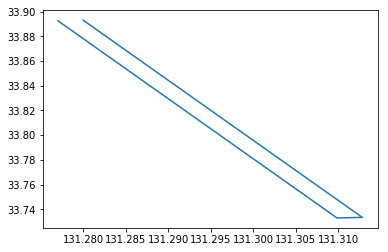

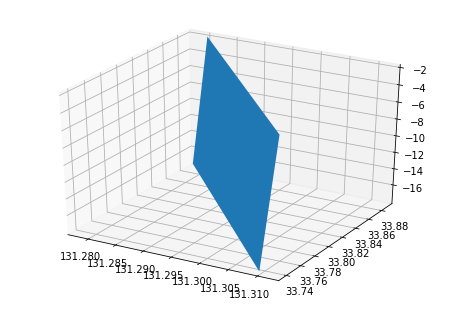

'MLTPLN(PLN((lon=131.28,lat=33.89,dep=2.0),(lon=131.31,lat=33.73,dep=2.0),(lon=131.31,lat=33.73,dep=18.0),(lon=131.28,lat=33.89,dep=18.0)))'

In [14]:
yesy['F019101'].shape.plot2d(), yesy['F019101'].shape.plot3d()
yesy['F019101'].shape.desc()

# Magnitudes

Conversion de la magnitude

def magnitude_conversion(mag):
    if mag < 0:
        mag = -round(mag, 2)
    else:
        mag = round(0.78 * mag + 1.08, 2)
    return mag

## Magnitudes caractéristiques

In [18]:
yesy['F019101'].mag.type, yesy['F019101'].mag.desc()

('CharacteristicMag', 'CHAR(mag=6.38)')

## Loi de Gutemberg Richter

GR(min=6.06,b_val=0.9,max=6.36)


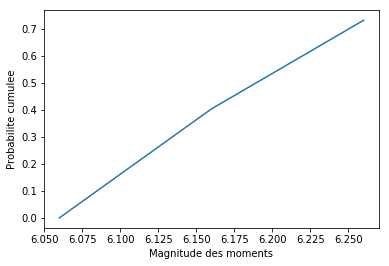

In [19]:
from EQCAT.magnitude import plot_gutenberg
plot_gutenberg(yesy['F005102'].mag.min_mag, yesy['F005102'].mag.b_val, yesy['F005102'].mag.max_mag)

###### Parameters for seismic activity evaluation and Fault shape of EarthQuake’s Traces Hardly Recognized (EQTHR) from surface evidences (P-Y2017-PRM_MAX_LND_A98F_EQTHR_EN.csv)

Fichier en blocs décrivant chacun une source de séisme

Une première ligne décrivant la loi de gutemberg richter doublement tronquée

| Column | Explanation               |
|-----------------------------------------|
| 01 | Fault code                        |
| 02 | Mean recurrence interval (Years) |
| 03 | The minimum magnitude          |
| 04 | The maximum magnitude          |
| 05 | b-value                        |
| 06 | Number of fault planes           |
| 07 | Fault name                        |

Puis une série de lignes décrivant chacune un des rectangles composant la surface de rupture

| Column | Explanation                                                                          |
|--------|--------------------------------------------------------------------------------------|
| 01     | Rectangular fault number                                                             |
| 02     | Longitude of the reference point of rectangular fault (Tokyo datum)                  |
| 03     | Latitude of the reference point of rectangular fault (Tokyo datum)                   |
| 04     | Longitude of the reference point of rectangular fault (Japanese Geodetic Datum 2000) |
| 05     | Latitude of the reference point of rectangular fault (Japanese Geodetic Datum 2000)  |
| 06     | Depth of the upper edge of rectangular fault (km)                                    |
| 07     | Length of rectangular fault (km)                                                     |
| 08     | Width of rectangular fault (km)                                                      |
| 09     | Strike angle (degree)                                                                |
| 10     | Dip angle (degree)                                                                   |

Extrait:

| F004501 | 12800   | 6.8    | 7.4     | 0.9    | 2 | Kiso-sanmyaku-seien fault zone (Main part/Northern segment) |    |      |    |
|---------|---------|--------|---------|--------|---|-------------------------------------------------------------|----|------|----|
| 1       | 137.603 | 35.58  | 137.6   | 35.583 | 2 | 14                                                          | 16 | 44.4 | 90 |
| 2       | 137.728 | 35.673 | 137.725 | 35.676 | 2 | 30                                                          | 18 | 20.6 | 40 |
| F004502 | 9000    | 6.3    | 6.3     | 0.9    | 1 | Kiso-sanmyaku-seien fault zone (Main part/Southern segment) |    |      |    |
| 1       | 137.586 | 35.514 | 137.583 | 35.517 | 2 | 9.4                                                         | 9  | 9.3  | 90 |

In [3]:
#Fonction qui regroupe le numéros des lignes qui commencent par une lettre dans une liste ie les lignes de magnitude

def detect_blocks(data):
    start_lines = []
    for i, line in enumerate(data):
        if re.search(r'[A-Z]', line):
            start_lines += [i]
    return start_lines


#Lecture d'une première ligne de bloc décrivant la loi de magnitude
#Création d'une loi de gutemberg richter doublement tronquée (voir GutenbergRichter) associée au code de la source

def parse_fault_info(line):
    flt_info = line.split(',')
    eq_code = flt_info[0]
    # On ne retient pas la période de retour car une information plus riche sur la loi de survenance de la source est disponible ailleurs
    # avract = float(flt_info[1])
    min_mag = float(flt_info[2])
    max_mag = float(flt_info[3])
    b_val = float(flt_info[4])
    nb_planes = int(flt_info[5])
    name = flt_info[6]
    if max_mag > min_mag:
        mag = GutenbergRichter(min_mag, b_val, max_mag)
    else:
        mag = CharacteristicMag(min_mag)
    return eq_code, mag, nb_planes, name

#Lecture d'une ligne décrivant un rectangle
#Création d'un rectangle (voir PlaneShape)

def parse_plane_info(line):
    pln_info = line.split(',')
    idx = int(pln_info[0])
    lon = float(pln_info[3])
    lat = float(pln_info[4])
    dep = float(pln_info[5])
    leng = float(pln_info[6])
    wid = float(pln_info[7])
    strike = float(pln_info[8])
    dip = float(pln_info[9])
    plane = PlaneShape(idx, lon, lat, dep, leng, wid, strike, dip)
    return plane


#Lecture du fichier
#Création d'un ensemble de plans (voir MultiPlaneShape)

def parse_eqthr(quakes):
    file_name = ""
    for name in os.listdir(hazard_inputs_path):
        if re.search('P-Y[0-9]{4}-PRM_MAX_LND_A98F_EQTHR_EN.csv', name):
            file_name = os.path.join(hazard_inputs_path, name)
            break
    fil = open(file_name)
    data = fil.readlines()[5:]
    start_lines = detect_blocks(data)
    print("Nombre de failles actives majeures EQTHR : " + str(len(start_lines)))
    #01-EQTHR
        
    mag_col_names =  ['Code', 'Magnitude', 'NbPlanes', 'Name']
    mag_report  = pd.DataFrame(columns = mag_col_names)
    pln_col_names =  ['Code', 'Magnitude', 'NbPlanes', 'Name']
    pln_report  = pd.DataFrame(columns = mag_col_names)
    for i in start_lines:
        eq_code, mag, nb_planes, name = parse_fault_info(data[i])
        mag_report.loc[len(mag_report)] = [eq_code, mag, nb_planes, name]
        plane_list = []
        for j in range(nb_planes):
            plane = parse_plane_info(data[i + j + 1])
            plane_list += [plane]
            pln_report.loc[len(pln_report)] = [plane, plane, plane, plane]
        shape = MultiPlaneShape(plane_list)
        quakes[eq_code] = {'code': eq_code, 'mag': mag, 'shape': shape, 'name': name}
    fil.close()
    return quakes
parse_eqthr({})

Nombre de failles acives EQTHR : 224


{'F000101': {'code': 'F000101',
  'mag': <EQCAT.magnitude.GutenbergRichter at 0x129489e8>,
  'name': 'Shibetsu fault zone',
  'shape': <EQCAT.shape.MultiPlaneShape at 0x129bf978>},
 'F000201': {'code': 'F000201',
  'mag': <EQCAT.magnitude.GutenbergRichter at 0x62992b0>,
  'name': 'Tokachi-heiya fault zone (Main part)',
  'shape': <EQCAT.shape.MultiPlaneShape at 0x12948b00>},
 'F000202': {'code': 'F000202',
  'mag': <EQCAT.magnitude.GutenbergRichter at 0x12948be0>,
  'name': 'Kochien fault',
  'shape': <EQCAT.shape.MultiPlaneShape at 0x12948b70>},
 'F000301': {'code': 'F000301',
  'mag': <EQCAT.magnitude.GutenbergRichter at 0x12948cc0>,
  'name': 'Furano fault zone (Western part)',
  'shape': <EQCAT.shape.MultiPlaneShape at 0x12948c50>},
 'F000302': {'code': 'F000302',
  'mag': <EQCAT.magnitude.GutenbergRichter at 0x12948da0>,
  'name': 'Furano fault zone (Eastern part)',
  'shape': <EQCAT.shape.MultiPlaneShape at 0x12948d30>},
 'F000401': {'code': 'F000401',
  'mag': <EQCAT.magnitude.G

###### Parameters for seismic activity evaluation 

| Earthquake type | File name                         |
|---------------------------------------------------|
| Parameters for seismic activity evaluation of Characteristic earthquakes occurring in major active fault zones (Maximum case) | P-2017-ACT_MAX_LND_A98F_EN.csv|
| Parameters for seismic activity evaluation of subduction-zone earthquakes (Maximum case)| P-2017 -PRM-ACT_MAX_PME_MTTL_EN.csv |
| Parameters for seismic activity evaluation of Earthquakes occurring on active faults other than major active fault zones | P-2017-PRM-ACT_AVR_LND_AGR1_EN.csv |

Ces 3 fichiers se présentent au même format et peuvent être lus comme des dataframes

Ils décrivent la loi de survenance d'une grande partie des sources

Chaque ligne décrit la loi de survenance d'une source

| Column | Explanation                                                                                                                                                                                                                                            |
|--------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| CODE   | Fault code                                                                                                                                                                                                                                             |
| PROC   | Stochastic process (BPT: BPT processes, POI: Poisson process, COM: Combined BPT and POI, BSI: BPT process (Simultaneous occurring model), PSI: Poisson process (Simultaneous occurring model),SIM: Simultaneous occurring model, XXX: None evaluation) |
| AVRACT | Mean recurrence interval (Years)                                                                                                                                                                                                                       |
| NEWACT | The time of the latest event (Years ago: from reference date)                                                                                                                                                                                          |
| ALPHA  | Variance                                                                                                                                                                                                                                               |
| P_T30  | Probability of occurrence in 30 years                                                                                                                                                                                                                  |
| P_T50  | Probability of occurrence in 50 years                                                                                                                                                                                                                  |
| NAME   | Fault name                                                                                                                                                                                                                                             |

In [ ]:
#Lecture des fichiers d'activité
#Création des lois de survenance (voir PoissonProcess et BrownianPTProcess)
def parse_activity(quakes):
    #Lecture des fichiers
    activity = pd.read_csv('hazard_inputs/P-Y2017-PRM-ACT_MAX_LND_A98F_EN.csv', skiprows=8, skipinitialspace=True,
                           index_col=0)
    activity2 = pd.read_csv('hazard_inputs/P-Y2017-PRM-ACT_AVR_LND_AGR1_EN.csv', skiprows=8, skipinitialspace=True,
                            index_col=0)
    activity = activity.append(activity2)
    activity2 = pd.read_csv('hazard_inputs/P-Y2017-PRM-ACT_MAX_PME_MTTL_EN.csv', skiprows=8, skipinitialspace=True,
                            index_col=0)
    activity = activity.append(activity2)
    for eq_code, row in activity.iterrows():
        #Processus de Poisson: un paramètre
        if row['PROC'] in ['POI', 'PSI'] and row['AVRACT'] != '-':
            process = PoissonProcess(row['AVRACT'])
        #Temps de premier passage: 3 paramètres
        elif row['PROC'] in ['BPT', 'BSI', 'COM']:
            process = BrownianPTProcess(row['AVRACT'], row['NEWACT'], row['ALPHA'])
        else:
            process = ''
        dico = {'process': process}
        if eq_code in quakes:
            quakes[eq_code].update(dico)
        else:
            dico.update({'code': eq_code, 'name': row['NAME']})
            quakes[eq_code] = dico
    return quakes


###### MultiActivity File (MultiActivity.csv)

Lecture des sources étant la réunion de plusieurs sources

On trouve le code, le nom de la source et la liste des codes des sources qu'elle réunit

| CODE    | NAME                                                        | SEGMENTS                |
|---------|-------------------------------------------------------------|-------------------------|
| F01220B | Nishiyama fault zone (Oshima-Oki segment/Nishiyama segment) | F012201;F012202         |
| F01220C | Nishiyama fault zone (Nishiyama segment/Kama-toge segment)  | F012202;F012203         |
| F01220A | Nishiyama fault zone (All segment)                          | F012201;F012202;F012203 |

In [ ]:
def parse_multi(quakes):
    df = pd.read_csv('hazard_inputs/MultiActivity.csv', index_col=0)
    for code, row in df.iterrows():
        quakes[code]['segments'] = row['SEGMENTS'].split(';')
        quakes[code]['process'] = 'multi'
    return quakes

In [ ]:

def parse_frequencies(quakes):
    codes1 = ['LND_CGR5_CRUST', 'LND_CIZU_CRUST', 'LND_CJPS_CRUST', 'PSE_CURA_CRUST']
    codes2 = ['PSE_CPCF_INTER', 'PSE_CPCF_INTRA', 'PSE_CPHL_INTER', 'PSE_CPHL_INTRA']
    for code in codes1:
        file_name = 'hazard_inputs/P-Y2017-PRM-ACT_' + code + '_CV_SM.csv'
        df = pd.read_csv(file_name, skiprows=7, skipinitialspace=True)
        l = code.split('_')
        code, typ = l[1], l[2]
        eqtype = {'CRUST': 1, 'INTER': 2, 'INTRA': 3}[typ]
        for _, row in df.iterrows():
            if row['FRQ'] > 0:
                process = YearFreqProcess(row['FRQ'])
                mag = GutenbergRichter(row['MMN'], row['BVL'])
                shape = PointShape(row['# MNO'], row['WLG'], row['WLA'], row['DEP'])  # , row['STR'], row['DIP']
                code3 = code + '_' + str(int(row['ANO'])) + '_' + str(int(row['# MNO']))
                quakes[code3] = {'code': code3, 'name': code3, 'process': process, 'mag': mag, 'shape': shape,
                                 'eqtype': eqtype}
    for code in codes2:
        file_name = 'hazard_inputs/P-Y2017-PRM-ACT_' + code + '_CV_SM.csv'
        df = pd.read_csv(file_name, skiprows=7, skipinitialspace=True)
        l = code.split('_')
        code, typ = l[1] + '_' + l[2], l[2]
        eqtype = {'CRUST': 1, 'INTER': 2, 'INTRA': 3}[typ]
        for _, row in df.iterrows():
            if row['FRQ'] > 0:
                process = YearFreqProcess(row['FRQ'])
                mag = GutenbergRichter(row['MMN'], row['BVL'])
                shape = PointShape(row['# MNO'], row['WLG'], row['WLA'], row['DEP'])  # , row['STR'], row['DIP']
                code3 = code + '_' + str(int(row['ANO'])) + '_' + str(int(row['# MNO']))
                quakes[code3] = {'code': code3, 'name': code3, 'process': process, 'mag': mag, 'shape': shape,
                                 'eqtype': eqtype}
    return quakes